# Lens model DESIJ0923+1829

Author: Mamunur Rashid

acknowledgement: Robin, Tanver

# import of standard python libraries


In [1]:
import h5py
import matplotlib.pyplot as plt
import emcee
import corner
import joblib

# import of standard python libraries
import numpy as np
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, util
from lenstronomy.Workflow.fitting_sequence import FittingSequence

%matplotlib inline

# importing Data

### Extracting the observed image data from a .h5 file

In [2]:
with h5py.File("DESIJ0923+1829_F140W.h5", "r") as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]
#kwargs_data

### Extracting the information about Point Spread Function(PSF) from a .h5 file

In [3]:
with h5py.File("psf_F140W.h5", "r") as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]
kwargs_psf["psf_type"] = "PIXEL"
# kwargs_psf

# Visualizing the image

/tmp/ipykernel_32355/4250926759.py:6: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")


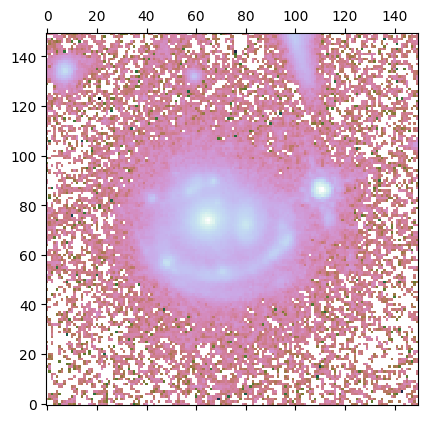

In [4]:
image_data = kwargs_data["image_data"]

#replace_negatives = np.vectorize(lambda x: 0 if x < 0 else x)
#image_data = replace_negatives(image_data)

plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")
# plt.grid(which='both', color='black')
# plt.minorticks_on()
# plt.grid(which='minor', color='black')
#image_data

#plt.show()

# Masking

## coordinate setup

In [5]:
ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)


## Masking regions

/tmp/ipykernel_32355/711628833.py:171: RuntimeWarning: invalid value encountered in log10
  axs[0].matshow(np.log10(image_data), origin="lower", cmap="cubehelix")
/tmp/ipykernel_32355/711628833.py:172: RuntimeWarning: divide by zero encountered in log10
  axs[1].matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")
/tmp/ipykernel_32355/711628833.py:172: RuntimeWarning: invalid value encountered in log10
  axs[1].matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")


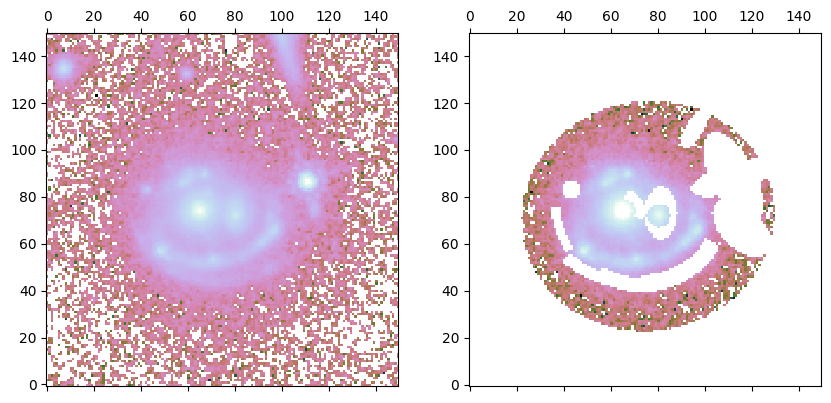

In [6]:

r = 4.3  # arcseconds
b = 3.9
lens_center_ra = 0
lens_center_dec = 0

# outlinig the lens system
mask_outer = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 0,
    lens_center_dec - 0.3,
    r,
    b,
    0.95*np.pi,
)


# big object at 2 o'clock
mask_ext_1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 2.9,
    lens_center_dec + 1.0,
    1.7,
    0.75,
    1.1,
)
# horizonal ray of big object at 2 o'clock
mask_ext_1_x = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 2.9,
    lens_center_dec + 1.0,
    1.5,
    0.5,
    -0.3,
)

# 10 o'clock near arc
mask_ext_2 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 2.59,
    lens_center_dec + 0.6,
    0.3,
    0.3,
    1.1,
)

# second arc, at 8 o'clock
mask_ext_arc_1 = mask_util.mask_half_moon(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 1.3 -0.5,
    lens_center_dec + 0.3,
    2.6,
    3.0,
    np.pi,
    np.pi/2
)
# second arc, at 5 o'clock
mask_ext_arc_2 = mask_util.mask_half_moon(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 0.2,
    lens_center_dec + 0.2,
    2.5,
    3.08,
    -np.pi,
    np.pi/1.5,
)
# second arc, at 6 o'clock
mask_ext_arc_3 = mask_util.mask_half_moon(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 0.2,
    lens_center_dec + 0.2,
    2.6,
    3.08,
    3,
    np.pi/4
)
# second arc, at 7 o'clock
mask_ext_arc_4 = mask_util.mask_half_moon(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 0.2,
    lens_center_dec + 0.2,
    2.8,
    3.1,
    1.9,
    np.pi/6
)

# main lense ellipse
mask_main = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 0.84,
    lens_center_dec - 0.12,
    0.25,
    0.25,
    0
)

# main lense, not to mask center
mask_main_cen = mask_util.mask_half_moon(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 0.84,
    lens_center_dec - 0.15,
    0.42,
    0.75,
    -np.pi/3,
    np.pi/1.75
)


# satellite ellipse
mask_sat_1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 0.45,
    lens_center_dec - 0.2,
    0.55,
    0.90,
    0
)

# satellite not to mask center
mask_sat_2 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 0.36,
    lens_center_dec - 0.28,
    0.4,
    0.4,
    0
)

mask_out_5 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 3.18,
    lens_center_dec - 0.7,
    1.2,
    0.7,
    np.pi/4
)

mask_out_1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 1.6,
    lens_center_dec + 2.7,
    0.8,
    0.3,
    np.pi/1.5
)

mask = (mask_outer) *  \
    (1 - mask_ext_1) * \
    (1 - mask_ext_1_x) * \
    (1 - mask_ext_2) * \
    (1-mask_ext_arc_1) * \
    (1-mask_ext_arc_2) * \
    (1-mask_ext_arc_3)  * \
    (1-mask_ext_arc_4) * \
    (1-(mask_sat_1 - mask_sat_2)) * \
    (1-mask_main_cen)*(1-mask_main) * \
    (1- mask_out_5)*(1-mask_out_1)

mask[mask >= 1] = 1
mask[mask < 0] = 0

mask = mask.reshape(num_pix, num_pix)
masked_image_data = np.multiply(image_data, mask)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].matshow(np.log10(image_data), origin="lower", cmap="cubehelix")
axs[1].matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")
plt.show()

# Building a lens model

Here, we build a lens model. The lens model can be thought of three
components: the lens galaxy's mass model, the lens galaxy's light model, and
the source galaxy's light model. We have to give a list of profiles for each
 component as shown in the next codecell.

The `'EPL'` lens mass profile stands for Elliptical Power Law. The form of
this convergence profile is given by:
$$\kappa(x, y) = \frac{3 - \gamma}{2} \left[ \frac{\theta_{\rm E}}{\sqrt{q
x^2 + y^2 / q}} \right]^{\gamma - 1}. $$

The position angle $\phi$ adjusts the orientation of the mass profile's
major axis. The ellipticity parameters $q$ and $\phi$ can be reformulated as
$$e_1 = \frac{1 - q}{1 + q} \cos 2\phi,$$
$$e_2 = \frac{1 - q}{1 + q} \sin 2\phi.$$

`lenstronomy` uses $e_1$ and $e_2$ instead of $q$ and $\phi$, because $e_1$
and $e_2$ are easier to handle in numerical optimization, for example, in
MCMC. You can check [here](https://github.com/lenstronomy/lenstronomy-tutorials/blob/main/Notebooks/GettingStarted/units_coordinates_parameters_definitions.ipynb) for more details on
parameter definitions and conventions used in `lenstronomy`.


Both the lens galaxy's and the source galaxy's light profiles are modeled
with Sersic function, which is given by:

$$I(x, y) = I_{\rm e} \exp \left[ -b_{n} \left\{ \left( \frac{\sqrt{q x^2
+ y^2/q}}{R_{\rm Sersic}} \right)^{1/n_{\rm Sersic}} - 1 \right\}
\right].$$

## Adding profiles

In [7]:
lens_model_list = ["EPL", "SHEAR", "SIE"]
source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]
lens_light_model_list = ["SERSIC_ELLIPSE", "SERSIC_ELLIPSE", "SERSIC_ELLIPSE"]

In this cell below, we have to specify the initial values, upper and lower
limits for the model parameters specific to each of the model components
specified in the above lists. The `kwargs_*_sigma` dictionaries/lists are
used to set the initial size of the search area within particle swarm
optimization (PSO) or MCMC.

## lens model (mass)

In [8]:
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

### EPL profile (lens)

In [9]:
lens_center_x = 0.84
lens_center_y = -0.12


fixed_lens.append({"gamma": 2})
kwargs_lens_init.append(
    {
        'theta_E': 1.7, 
        'e1': 0.13890877524269477, 
        'e2': 0.036002142386423706, 
        "center_x": lens_center_x,
        "center_y": lens_center_y
    }
)
kwargs_lens_sigma.append(
    {
        "theta_E": 0.1,
        "e1": 0.1,
        "e2": 0.1,
        "center_x": 0.1,
        "center_y": 0.1
    }
)
kwargs_lower_lens.append(
    {
        "theta_E": 0.5,
        "e1": -0.2,
        "e2": -0.2,
        "center_x": lens_center_x - 0.3 ,
        "center_y": lens_center_y - 0.3
    }
)
kwargs_upper_lens.append(
    {
        "theta_E": 2.0,
        "e1": 0.2,
        "e2": 0.2,
        "center_x": lens_center_x + 0.3,
        "center_y": lens_center_y + 0.3
    }
)

### SHEAR profile (lens)

In [10]:
fixed_lens.append({"ra_0": 0, "dec_0": 0})
kwargs_lens_init.append({
    'gamma1': 0.17397031014274053, 
    'gamma2': -0.03668800209282275
    })
kwargs_lens_sigma.append({"gamma1": 0.05, "gamma2": 0.05})
kwargs_lower_lens.append({"gamma1": -0.3, "gamma2": -0.3})
kwargs_upper_lens.append({"gamma1": 0.3, "gamma2": 0.3})

### SIE profile (satelite lens)

In [11]:
satellite_center_x = -0.36
satellite_center_y = -0.28
satellite_centroid_bound = 1


fixed_lens.append({})
kwargs_lens_init.append(
    {
        'theta_E': 0.2, 
        'e1': -0.1419453537419886, 
        'e2': -0.025750973350839094, 
        "center_x": satellite_center_x, 
        "center_y": satellite_center_y,
    }
)
kwargs_lens_sigma.append(
    {
        "theta_E": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": satellite_centroid_bound / 5,
        "center_y": satellite_centroid_bound / 5,
    }
)
kwargs_lower_lens.append(
    {
        "theta_E": 0.15,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": satellite_center_x - 0.2,
        "center_y": satellite_center_y - 0.2,
    }
)
kwargs_upper_lens.append(
    {
        "theta_E": 1.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": satellite_center_x + 0.2,
        "center_y": satellite_center_y + 0.2,
    }
)

## lens light model

In [12]:
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

### 1st SERSIC (Primary lens)

In [13]:
fixed_lens_light.append({"n_sersic": 1})
kwargs_lens_light_init.append(
    {
        'amp': 1, 
        'R_sersic': 1.871086721556519,
        'e1': 0.13890877524269477, 
        'e2': 0.036002142386423706, 
        'center_x': lens_center_x, 
        'center_y': lens_center_y
    }
)
kwargs_lens_light_sigma.append(
    {
        "R_sersic": 0.1,
        "e1": 0.1,
        "e2": 0.1,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 0.1,
    }
)
kwargs_lower_lens_light.append(
    {
        "R_sersic": 1.0, 
        "e1": -0.2,
        "e2": -0.2,
        'center_x': lens_center_x - 0.2, 
        'center_y': lens_center_y - 0.2,
        "amp": -2,
    }
)
kwargs_upper_lens_light.append(
    {
        "R_sersic": 2.2,
        "e1": 0.2,
        "e2": 0.2,
        'center_x': lens_center_x + 0.2, 
        'center_y': lens_center_y + 0.2,
        "amp": 5,
    }
)

### 2nd SERSIC (satelite lens)

In [14]:
fixed_lens_light.append({"n_sersic": 1.0})
kwargs_lens_light_init.append(
    {
        'amp': 1, 
        'R_sersic': 0.3, 
        'e1': -0.1419453537419886, 
        'e2': -0.025750973350839094, 
        'center_x': satellite_center_x, 
        'center_y': satellite_center_y,
    }
)
kwargs_lens_light_sigma.append(
    {
        "R_sersic": 0.1,
        "e1": 0.1,
        "e2": 0.1,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 0.1
    }
)
kwargs_lower_lens_light.append(
    {
        "R_sersic": 0.15,
        "e1": -0.4,
        "e2": -0.3,
        'center_x': satellite_center_x - 0.2, 
        'center_y': satellite_center_y - 0.2,
        "amp": -2
    }
)
kwargs_upper_lens_light.append(
    {
        "R_sersic": 1.0,
        "e1": 0.3,
        "e2": 0.3,
        'center_x': satellite_center_x + 0.2, 
        'center_y': satellite_center_y + 0.2,
        "amp": 5
    }
)

### 3rd SERSIC (free lens)

In [15]:
fixed_lens_light.append({"n_sersic": 4.0})
kwargs_lens_light_init.append(
    {
        'amp': 1, 
        'R_sersic': 0.30582823959626027, 
        'e1': -0.010348971621036391, 
        'e2': -0.018546490448998948, 
        'center_x': 0.8612823026525991, 
        'center_y': -0.11094081607706244
    }
)
kwargs_lens_light_sigma.append(
    {
        "R_sersic": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 0.1,
    }
)
kwargs_lower_lens_light.append(
    {
        "R_sersic": 0.01,
        "e1": -0.1,
        "e2": -0.1,
        "center_x": lens_center_x-1.0,
        "center_y": lens_center_y-1.0,
        "amp": -2,
    }
)
kwargs_upper_lens_light.append(
    {
        "R_sersic": 2,
        "e1": 0.1,
        "e2": 0.1,
        "center_x": lens_center_x + 1.0,
        "center_y": lens_center_y + 1.0,
        "amp": 5,
    }
)


## source galaxy

In [16]:
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

### 1st SERSIC

In [17]:
fixed_source.append({'n_sersic': 1})
kwargs_source_init.append(
    {
        'amp': 1, 
        'R_sersic': 0.6,
        'e1': -0.11032648332006491, 
        'e2': -0.16054648640553162, 
        'center_x': 0.33687806731119596, 
        'center_y': -0.4400025576650069
    }
)
kwargs_source_sigma.append(
    {
        "R_sersic": 0.1,
        "e1": 0.1,
        "e2": 0.1,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 0.1,
    }
)
kwargs_lower_source.append(
    {
        "R_sersic": 0.01,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -1.5,
        "center_y": -1.5,
        "amp": -2,
    }
)
kwargs_upper_source.append(
    {
        "R_sersic": 1.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 1.5,
        "center_y": 1.5,
        "amp": 5,
    }
)

### SHAPELET profile

In [18]:
fixed_source.append({"n_max": 14})
kwargs_source_init.append({
    'beta': 0.03871689555944386, 
    'center_x': 0.33687806731119596, 
    'center_y': -0.4400025576650069})
kwargs_source_sigma.append({"beta": 0.01, "center_x": 0.1, "center_y": 0.1})
kwargs_lower_source.append({"beta": 0.01, "center_x": -1.5, "center_y": -1.5})
kwargs_upper_source.append({"beta": 0.1, "center_x": 1.5, "center_y": 1.5})

## parameter gathering

### Joint constraints

In [19]:
joint_lens_with_light = [[0, 0, ["center_x", "center_y", "e1", "e2"]],
                        [1, 2, ["center_x", "center_y", "e1", "e2"]]]

joint_source_with_source = [[0, 1, ["center_x", "center_y"]]]

### profile parameter gathering

In [20]:
lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]
lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]
source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]

### defining kwargs_param dict

In [21]:
# Combining all the above specification in the `kwargs_params` dictionary
kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}

kwargs_constraints = {
    "joint_lens_with_light": joint_lens_with_light,
    #    'joint_lens_light_with_lens_light': joint_lens_light_with_lens_light,
    "joint_source_with_source": joint_source_with_source,
}

### Numerical settings

In [22]:
kwargs_likelihood = {"check_bounds": True, "image_likelihood_mask_list": [mask]}

kwargs_numerics = {"supersampling_factor": 1, "supersampling_convolution": False}

### Combining all the information to be sent to lenstronomy

In [23]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band",
}

# PSO run

In [24]:
fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

fitting_kwargs_list = [
    ["PSO", {"sigma_scale": 1.0, "n_particles": 200, "n_iterations": 300,}]
]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
Max iteration reached! Stopping.
-1.1833773168784125 reduced X^2 of best position
-3598.0587319688134 log likelihood
6081 effective number of data points
[{'theta_E': 1.5927005006158603, 'gamma': 2, 'e1': 0.1158655085731877, 'e2': 0.07792893396456255, 'center_x': 0.7291426318691183, 'center_y': -0.05680578081950058}, {'gamma1': 0.16382589994148106, 'gamma2': -0.005228615302180288, 'ra_0': 0, 'dec_0': 0}, {'theta_E': 0.1820570894971211, 'e1': -0.12780081638231108, 'e2': -0.02337939588259866, 'center_x': -0.37976501424586506, 'center_y': -0.2499945511502251}] lens result
[{'amp': 1, 'R_sersic': 0.19649682758051226, 'n_sersic': 1, 'e1': 0.011933867238697538, 'e2': -0.14514907617649375, 'center_x': 0.41604400557880916, 'center_y': -0.4588939764479661}, {'amp': 1, 'n_max': 14, 'beta': 0.054134025332228775, 'center_x': 0.41604400557880916, 'center_y': -0.458893

## joblib

In [25]:
kwargs_result = fitting_seq.best_fit(bijective=False)
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed

init_samples = None  # can be not `None` for MCMC

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]

output = [kwargs_result, multi_band_list_out, chain_list, kwargs_fixed_out]

output_path = "./DESIJ0923+1829_pso_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

## Visualizing the fitted model

-1.155075029319933 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.155075029319956


/usr/lib/python3.11/site-packages/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/usr/lib/python3.11/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/usr/lib/python3.11/site-packages/lenstronomy/Plots/model_band_plot.py:136: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,


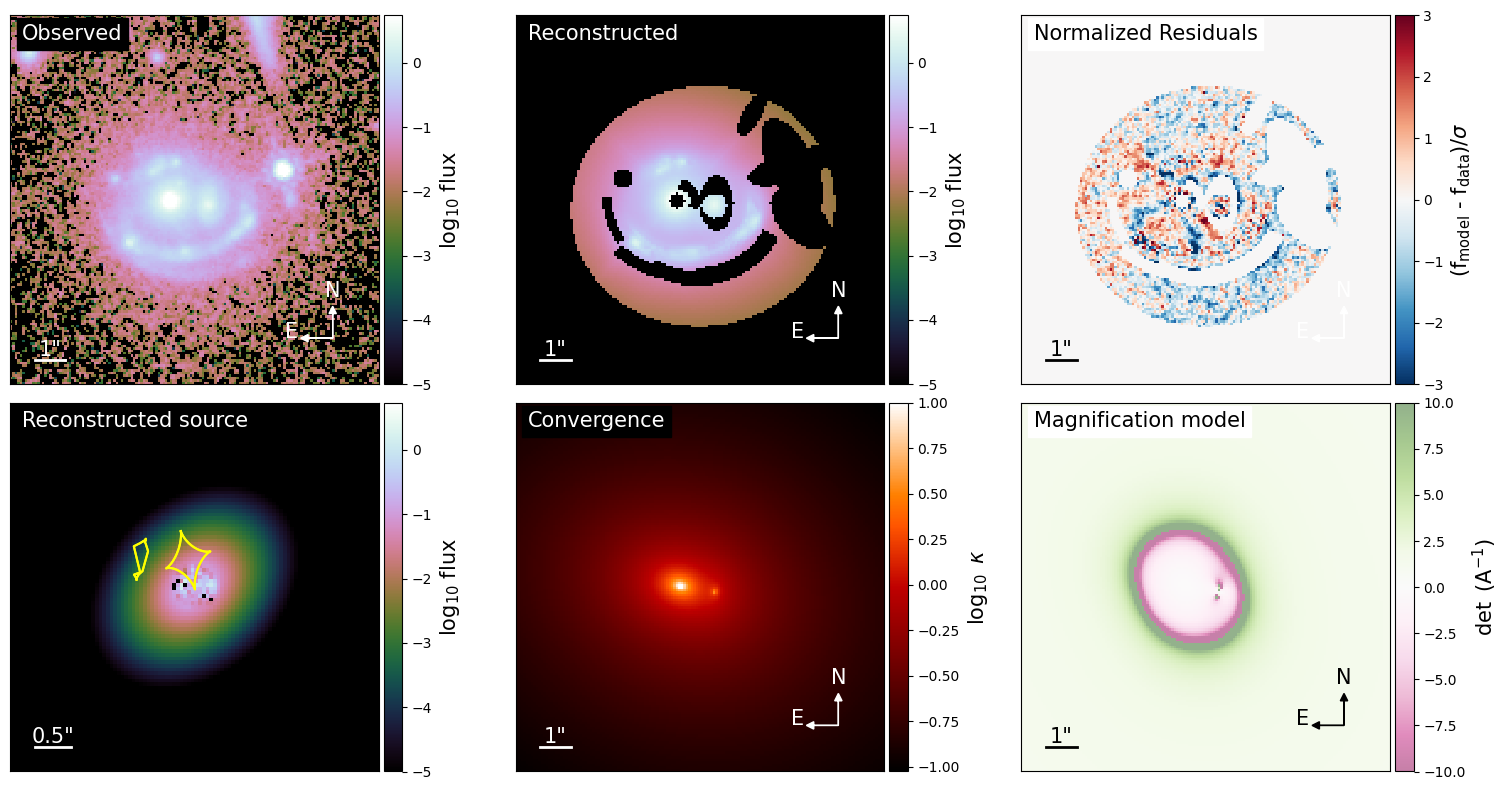

/usr/lib/python3.11/site-packages/lenstronomy/Plots/model_band_plot.py:506: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,


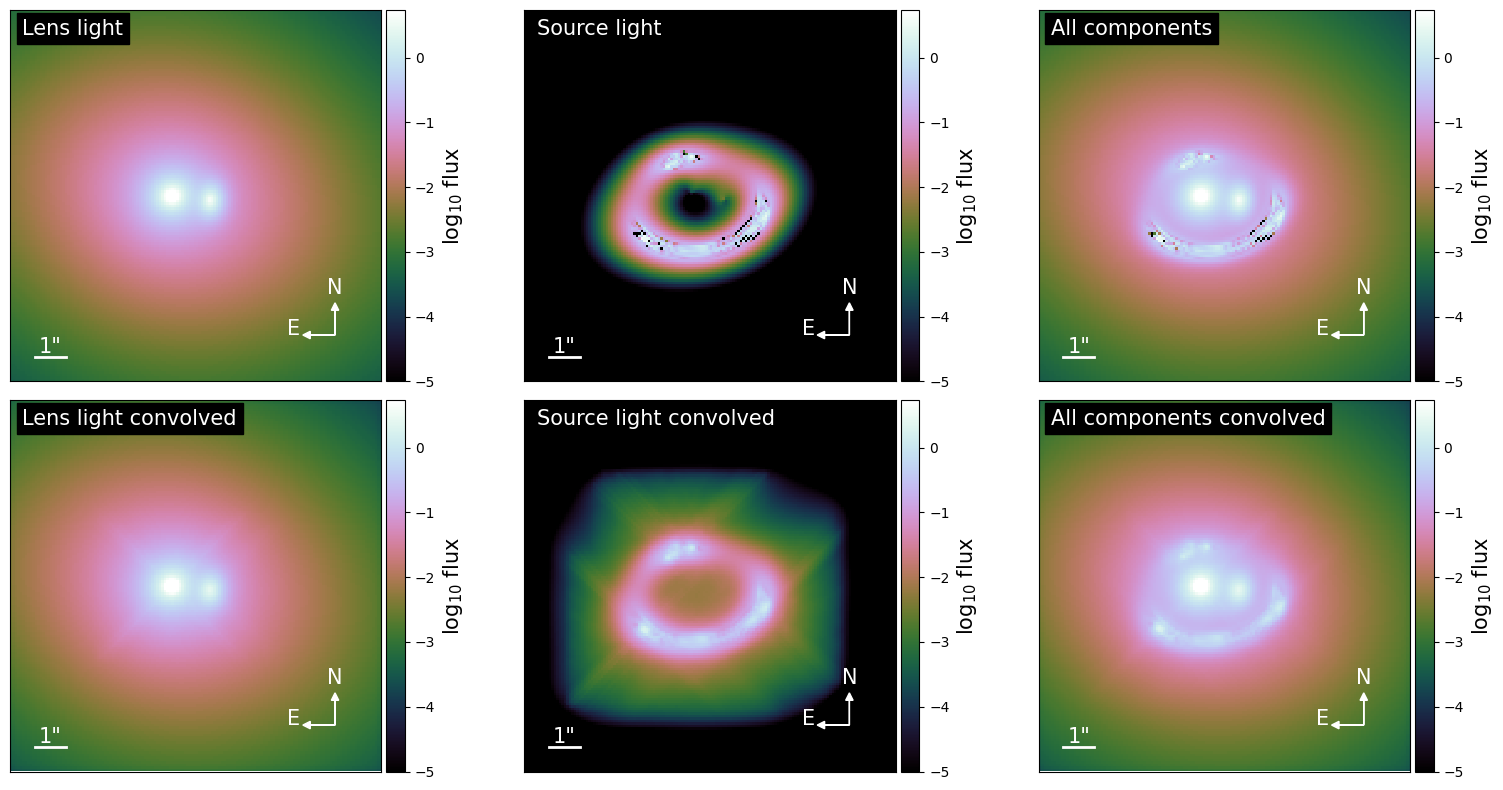

{'kwargs_lens': [{'theta_E': 1.5927005006158603, 'gamma': 2, 'e1': 0.1158655085731877, 'e2': 0.07792893396456255, 'center_x': 0.7291426318691183, 'center_y': -0.05680578081950058}, {'gamma1': 0.16382589994148106, 'gamma2': -0.005228615302180288, 'ra_0': 0, 'dec_0': 0}, {'theta_E': 0.1820570894971211, 'e1': -0.12780081638231108, 'e2': -0.02337939588259866, 'center_x': -0.37976501424586506, 'center_y': -0.2499945511502251}], 'kwargs_source': [{'amp': 1, 'R_sersic': 0.19649682758051226, 'n_sersic': 1, 'e1': 0.011933867238697538, 'e2': -0.14514907617649375, 'center_x': 0.41604400557880916, 'center_y': -0.4588939764479661}, {'amp': 1, 'n_max': 14, 'beta': 0.054134025332228775, 'center_x': 0.41604400557880916, 'center_y': -0.4588939764479661}], 'kwargs_lens_light': [{'amp': 1, 'R_sersic': 2.199977506152634, 'n_sersic': 1, 'e1': 0.1158655085731877, 'e2': 0.07792893396456255, 'center_x': 0.7291426318691183, 'center_y': -0.05680578081950058}, {'amp': 1, 'R_sersic': 0.2838181196844952, 'n_sersic

In [26]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(
    ax=axes[0, 2],
    v_min=-3,
    v_max=3,
    cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0],
    deltaPix_source=0.05,
    with_caustics=True,
    scale_size=0.5,
    numPix=100
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=0.0,
    hspace=0.05
)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=0.0,
    hspace=0.05
)
plt.show()
print(kwargs_result)